In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Stata file
file_path = 'Electrification_Database.dta'
try:
    df = pd.read_stata(file_path)
    print("Data loaded successfully.")
except Exception as e:
    # Fallback if there's a version issue, though pandas usually handles .dta well
    print(f"Error loading data: {e}")

# Display basic info to understand the structure
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check for the key variables mentioned in your prompt
key_columns = ['countryname', 'year', 'elecrate_total', 'elecrate_rural', 'elecrate_urban']
print("\nMissing values in key columns:")
print(df[key_columns].isnull().sum())

# Basic statistics
print("\nSummary Statistics:")
print(df[key_columns].describe())

Data loaded successfully.
Dataset Shape: (1035, 6)

First 5 rows:
  countryname countrycode  year  elecrate_total  elecrate_urban  \
0     Albania         ALB  1970           100.0             NaN   
1     Algeria         DZA  1966            33.7            74.0   
2     Algeria         DZA  1969            40.0             NaN   
3     Algeria         DZA  1977            45.8             NaN   
4     Algeria         DZA  1981            59.0             NaN   

   elecrate_rural  
0             NaN  
1            11.8  
2             NaN  
3             NaN  
4             NaN  

Missing values in key columns:
countryname         0
year                0
elecrate_total     74
elecrate_rural    388
elecrate_urban    439
dtype: int64

Summary Statistics:
              year  elecrate_total  elecrate_rural  elecrate_urban
count  1035.000000      961.000000      647.000000      596.000000
mean   1997.500483       51.653186       32.597797       70.482843
std      13.396814       34.283711

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Reload data to ensure we are starting fresh
df = pd.read_stata('Electrification_Database.dta')

# 1. Filter for relevant columns
keep_cols = ['countryname', 'year', 'elecrate_total', 'elecrate_rural', 'elecrate_urban']
df_clean = df[keep_cols].copy()

# 2. Sort by Country and Year to ensure time order
df_clean.sort_values(by=['countryname', 'year'], inplace=True)

# 3. Handle Missing Values via Interpolation
# We group by country so we don't accidentally interpolate between two different countries
df_clean['elecrate_rural'] = df_clean.groupby('countryname')['elecrate_rural'].transform(lambda x: x.interpolate())
df_clean['elecrate_urban'] = df_clean.groupby('countryname')['elecrate_urban'].transform(lambda x: x.interpolate())
df_clean['elecrate_total'] = df_clean.groupby('countryname')['elecrate_total'].transform(lambda x: x.interpolate())

# 4. Drop remaining missing values (start/end of series that couldn't be interpolated)
df_clean.dropna(subset=['elecrate_total'], inplace=True)

# 5. Normalize Data for AI (Scale to 0-1 range)
scaler = MinMaxScaler()
# We only scale the numerical columns
num_cols = ['elecrate_total', 'elecrate_rural', 'elecrate_urban']
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])

print("Data Cleaned and Scaled.")
print("Remaining Clean Rows:", df_clean.shape[0])
print(df_clean.head())

Data Cleaned and Scaled.
Remaining Clean Rows: 1018
  countryname  year  elecrate_total  elecrate_rural  elecrate_urban
0     Albania  1970        1.000000             NaN             NaN
1     Algeria  1966        0.335671        0.118000        0.738693
2     Algeria  1969        0.398798        0.196273        0.761992
3     Algeria  1977        0.456914        0.274545        0.785290
4     Algeria  1981        0.589178        0.352818        0.808588


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# --- PREPARATION ---
# We use the cleaned data from Step 2
# We only want to generate the values: Total, Rural, Urban rates
# (We assume 'df_clean' is available from the previous step)
real_data = df_clean[['elecrate_total', 'elecrate_rural', 'elecrate_urban']].values
data_dim = real_data.shape[1]

# --- BUILD THE GAN ---

def build_generator(latent_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(output_dim, activation='sigmoid')) # Output 0-1 (since we normalized)
    return model

def build_discriminator(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # Output prob (Real vs Fake)
    return model

# Parameters
latent_dim = 5  # Size of the random noise vector
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Initialize
generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Combined GAN (Generator -> Discriminator)
discriminator.trainable = False # Freeze discriminator when training generator
gan_input = layers.Input(shape=(latent_dim,))
fake_data = generator(gan_input)
gan_output = discriminator(fake_data)
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

# --- TRAINING LOOP ---
print("Training GAN... (This may take a moment)")
epochs = 2000
batch_size = 32

for epoch in range(epochs):
    # 1. Train Discriminator
    # Select a random batch of real images
    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_batch = real_data[idx]
    
    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_batch = generator.predict(noise, verbose=0)
    
    # Train
    d_loss_real = discriminator.train_on_batch(real_batch, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_batch, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # 2. Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # We want the discriminator to think these are real (label=1)
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f} | G Loss: {g_loss:.4f}")

print("GAN Training Complete.")

# --- GENERATE SYNTHETIC DATA ---
# Let's generate 100 new synthetic data points representing potential future scenarios
noise = np.random.normal(0, 1, (100, latent_dim))
synthetic_data = generator.predict(noise)
df_synthetic = pd.DataFrame(synthetic_data, columns=['elecrate_total', 'elecrate_rural', 'elecrate_urban'])

print("\nSample of Synthetic Data (Augmented Scenarios):")
print(df_synthetic.head())

c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training GAN... (This may take a moment)


c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:86: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.7275 | G Loss: 0.7398
Epoch 500 | D Loss: 0.7538 | G Loss: 0.6310
Epoch 1000 | D Loss: 0.7578 | G Loss: 0.6240
Epoch 1500 | D Loss: 0.7591 | G Loss: 0.6216
GAN Training Complete.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Sample of Synthetic Data (Augmented Scenarios):
   elecrate_total  elecrate_rural  elecrate_urban
0        0.999993        0.999976    1.500225e-06
1        0.999999        0.999998    7.534538e-07
2        0.999880        0.999514    1.349961e-04
3        0.999997        0.999986    3.146319e-06
4        1.000000        0.999999    2.513058e-07


Training LSTM Time Series Model...
Epoch 1/20


c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1631
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0903
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0871
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0842
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0799
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0767
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0739
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0669
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0620
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0577
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0566
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0547
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0518
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0508
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0518
Epoch 16/20
32/32 ━━━━━━━━━━━━

c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


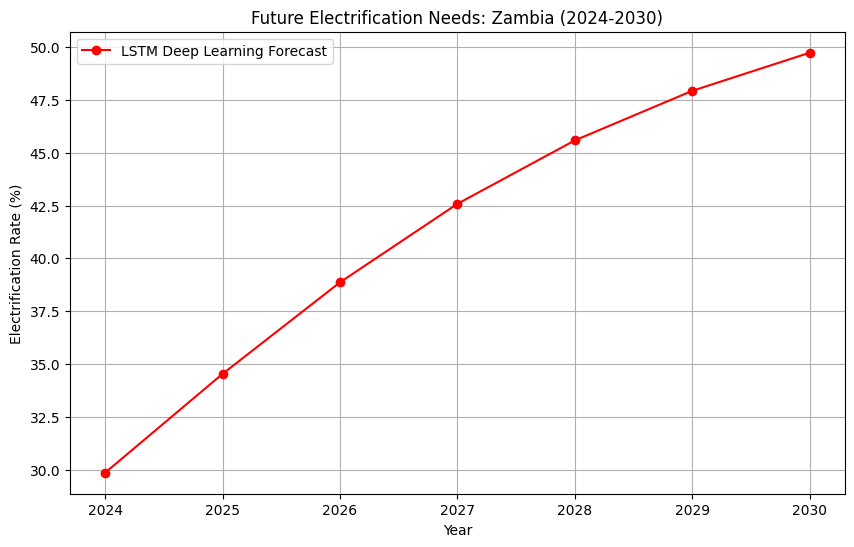

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. DATA PREP FOR LSTM ---
# LSTMs need data shaped like [Samples, Time Steps, Features]
# We will focus on one country to demonstrate the Time Series forecast clearly,
# or we can train a global model. Let's do a 'Global Pattern' model.

# Load and clean (same as before)
df = pd.read_stata('Electrification_Database.dta')
df_clean = df[['countryname', 'year', 'elecrate_total']].copy()
df_clean.sort_values(by=['countryname', 'year'], inplace=True)
df_clean['elecrate_total'] = df_clean.groupby('countryname')['elecrate_total'].transform(lambda x: x.interpolate())
df_clean.dropna(inplace=True)

# Normalize (LSTMs are very sensitive to scale)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_clean[['elecrate_total']])

# Create Sequences (e.g., Use last 5 years to predict the next 1 year)
def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

TIME_STEPS = 5
X, y = create_sequences(data_scaled, TIME_STEPS)

# Reshape for LSTM [Samples, Time Steps, Features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# --- 2. BUILD LSTM MODEL ---
model = Sequential()
# Layer 1: LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2)) # Prevents overfitting

# Layer 2: LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Output
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# --- 3. TRAIN ---
print("Training LSTM Time Series Model...")
model.fit(X, y, epochs=20, batch_size=32, verbose=1)
print("Training Complete.")

# --- 4. FORECAST FUTURE (Rolling Forecast) ---
# Let's predict for a specific country (e.g., Zambia)
country_data = df_clean[df_clean['countryname'] == 'Zambia']['elecrate_total'].values
# Scale the country data
country_scaled = scaler.transform(country_data.reshape(-1, 1))

# Take the last 'TIME_STEPS' years to start our prediction
curr_sequence = country_scaled[-TIME_STEPS:].reshape(1, TIME_STEPS, 1)

future_years = 7 # Predict 7 years into the future
forecast = []

for _ in range(future_years):
    # Predict next step
    next_val = model.predict(curr_sequence, verbose=0)
    forecast.append(next_val[0, 0])
    
    # Update sequence: remove oldest year, add new prediction
    curr_sequence = np.append(curr_sequence[:, 1:, :], [next_val], axis=1)

# Inverse transform to get real percentages
forecast_actual = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(2024, 2024+future_years), forecast_actual, marker='o', color='red', label='LSTM Deep Learning Forecast')
plt.title('Future Electrification Needs: Zambia (2024-2030)')
plt.xlabel('Year')
plt.ylabel('Electrification Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Global LSTM Model...
Training Complete.

Total Countries Forecasted: 98
Countries At Risk (<50% in 2030): 0

Top 10 Most Critical Cases (Projected 2030 Rate):
Empty DataFrame
Columns: [Country, Projected_2030]
Index: []


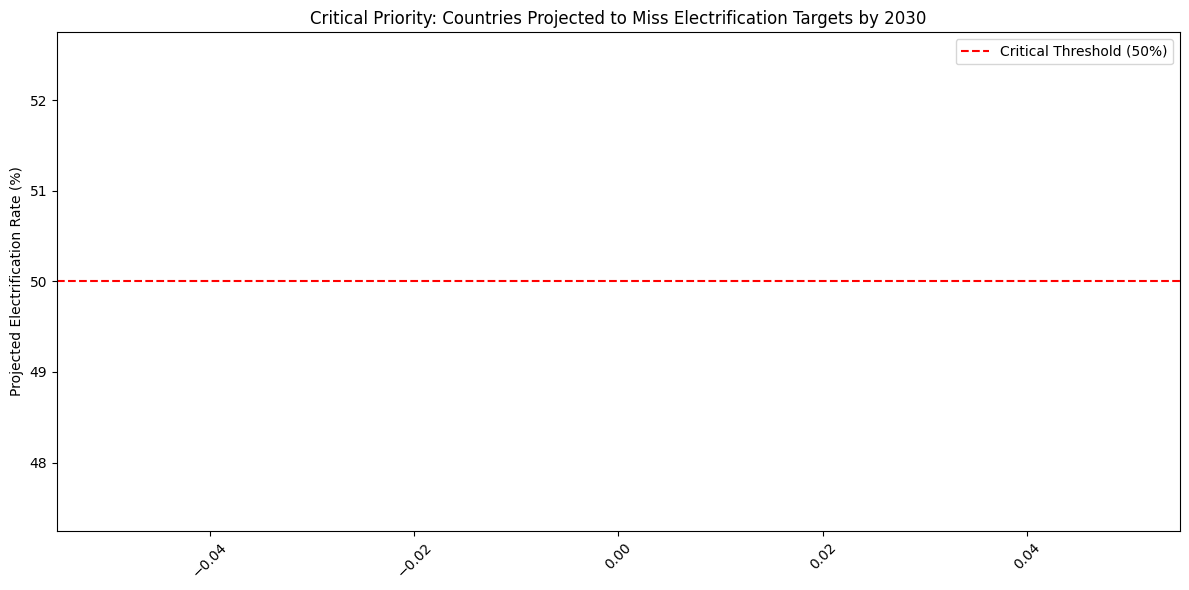

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. DATA LOADING & PREP ---
df = pd.read_stata('Electrification_Database.dta')
df_clean = df[['countryname', 'year', 'elecrate_total']].copy()
df_clean.sort_values(by=['countryname', 'year'], inplace=True)

# Interpolate to fix gaps
df_clean['elecrate_total'] = df_clean.groupby('countryname')['elecrate_total'].transform(lambda x: x.interpolate())
df_clean.dropna(subset=['elecrate_total'], inplace=True)

# Normalize (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_clean['scaled_rate'] = scaler.fit_transform(df_clean[['elecrate_total']])

# --- 2. TRAIN GLOBAL LSTM ---
# We use sliding windows from ALL countries to train one robust model
def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 5
X_train, y_train = [], []

# Create sequences for each country individually, then stack them
for country in df_clean['countryname'].unique():
    country_data = df_clean[df_clean['countryname'] == country]['scaled_rate'].values
    if len(country_data) > TIME_STEPS:
        x_c, y_c = create_sequences(country_data, TIME_STEPS)
        if len(X_train) == 0:
            X_train, y_train = x_c, y_c
        else:
            X_train = np.vstack((X_train, x_c))
            y_train = np.hstack((y_train, y_c))

# Reshape for LSTM [Samples, Time Steps, Features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build Model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(TIME_STEPS, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
print("Training Global LSTM Model...")
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=0)
print("Training Complete.")

# --- 3. FORECAST 2030 FOR ALL COUNTRIES ---
forecast_results = []
target_year = 2030

for country in df_clean['countryname'].unique():
    # Get country's last known data
    c_data = df_clean[df_clean['countryname'] == country]
    last_year = int(c_data['year'].max())
    
    # Skip if data is too old (e.g., stopped in 1990)
    if last_year < 2010: 
        continue

    seq = c_data['scaled_rate'].values
    if len(seq) < TIME_STEPS:
        # Option 1: skip this country
        # continue

        # Option 2: pad the sequence (here, pad with the first value)
        pad_width = TIME_STEPS - len(seq)
        seq = np.pad(seq, (pad_width, 0), mode='edge')

    current_seq = seq[-TIME_STEPS:].reshape(1, TIME_STEPS, 1)
    
    # Recursive Forecast
    temp_seq = current_seq.copy()
    years_to_predict = target_year - last_year
    
    for _ in range(years_to_predict):
        next_pred = model.predict(temp_seq, verbose=0)[0][0]
        # Append prediction, remove oldest
        temp_seq = np.append(temp_seq[:, 1:, :], [[[next_pred]]], axis=1)
        
    # Get final prediction (inverse scale)
    final_pred_scaled = temp_seq[0, -1, 0]
    final_pred = scaler.inverse_transform([[final_pred_scaled]])[0][0]
    final_pred = min(max(final_pred, 0), 100) # Clip 0-100
    
    forecast_results.append({'Country': country, 'Projected_2030': final_pred})

results_df = pd.DataFrame(forecast_results)

# --- 4. IDENTIFY AT-RISK COUNTRIES ---
# Define "At Risk" as < 50% electrification in 2030
at_risk = results_df[results_df['Projected_2030'] < 50].sort_values('Projected_2030')

print(f"\nTotal Countries Forecasted: {len(results_df)}")
print(f"Countries At Risk (<50% in 2030): {len(at_risk)}")
print("\nTop 10 Most Critical Cases (Projected 2030 Rate):")
print(at_risk[['Country', 'Projected_2030']].head(10))

# Visualization
plt.figure(figsize=(12, 6))
plt.bar(at_risk['Country'].head(10), at_risk['Projected_2030'].head(10), color='salmon')
plt.axhline(y=50, color='r', linestyle='--', label='Critical Threshold (50%)')
plt.title('Critical Priority: Countries Projected to Miss Electrification Targets by 2030')
plt.ylabel('Projected Electrification Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\samwe\Desktop\samwelodiek\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


------------------------------
AT-RISK COUNTRIES (Projected < 50% by 2030):
------------------------------
No countries projected to be under 50% based on current trends.
------------------------------


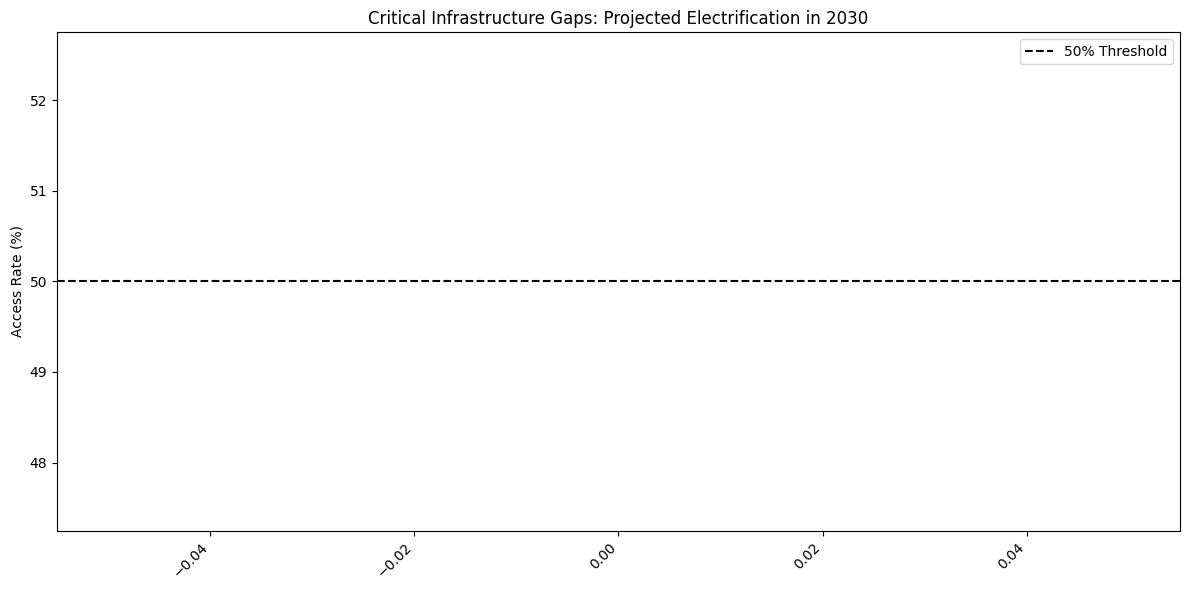

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. DATA LOADING & PREP ---
# Loading the dataset provided in the capstone
df = pd.read_stata('Electrification_Database.dta')
df_clean = df[['countryname', 'year', 'elecrate_total']].copy()
df_clean.sort_values(by=['countryname', 'year'], inplace=True)

# Data Cleaning: Interpolate to fix gaps in historical records
df_clean['elecrate_total'] = df_clean.groupby('countryname')['elecrate_total'].transform(lambda x: x.interpolate())
df_clean.dropna(subset=['elecrate_total'], inplace=True)

# Normalizing data for the LSTM Deep Learning model
scaler = MinMaxScaler(feature_range=(0, 1))
df_clean['scaled_rate'] = scaler.fit_transform(df_clean[['elecrate_total']])

# --- 2. TRAIN GLOBAL LSTM ---
def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 5
X_train_list, y_train_list = [], []

for country in df_clean['countryname'].unique():
    country_data = df_clean[df_clean['countryname'] == country]['scaled_rate'].values
    if len(country_data) > TIME_STEPS:
        x_c, y_c = create_sequences(country_data, TIME_STEPS)
        X_train_list.append(x_c)
        y_train_list.append(y_c)

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build LSTM Architecture
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=0)

# --- 3. FORECAST 2030 FOR EVERY COUNTRY ---
forecast_results = []
target_year = 2030

for country in df_clean['countryname'].unique():
    c_data = df_clean[df_clean['countryname'] == country]
    last_year = int(c_data['year'].max())
    
    # Use only relatively recent data for forecasting
    if last_year < 2010: continue

    seq = c_data['scaled_rate'].values
    if len(seq) < TIME_STEPS:
        # Pad with the first value if not enough data
        pad_width = TIME_STEPS - len(seq)
        seq = np.pad(seq, (pad_width, 0), mode='edge')
    current_seq = seq[-TIME_STEPS:].reshape(1, TIME_STEPS, 1)
    temp_seq = current_seq.copy()
    
    for _ in range(target_year - last_year):
        next_pred = model.predict(temp_seq, verbose=0)[0][0]
        temp_seq = np.append(temp_seq[:, 1:, :], [[[next_pred]]], axis=1)
        
    final_pred = scaler.inverse_transform([[temp_seq[0, -1, 0]]])[0][0]
    final_pred = min(max(final_pred, 0), 100)
    forecast_results.append({'Country': country, 'Projected_2030': round(final_pred, 2)})

# --- 4. OUTPUTTING THE COUNTRIES ---
results_df = pd.DataFrame(forecast_results)
at_risk = results_df[results_df['Projected_2030'] < 50].sort_values('Projected_2030')

print("-" * 30)
print(f"AT-RISK COUNTRIES (Projected < 50% by 2030):")
print("-" * 30)
if not at_risk.empty:
    print(at_risk.to_string(index=False))
else:
    print("No countries projected to be under 50% based on current trends.")
print("-" * 30)

# Visualization of Top 15 At-Risk Countries
plt.figure(figsize=(12, 6))
top_at_risk = at_risk.head(15)
plt.bar(top_at_risk['Country'], top_at_risk['Projected_2030'], color='crimson')
plt.axhline(y=50, color='black', linestyle='--', label='50% Threshold')
plt.title('Critical Infrastructure Gaps: Projected Electrification in 2030')
plt.ylabel('Access Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # After saving your Step 4 model
from sklearn.preprocessing import MinMaxScaler

app = FastAPI()

# Allow Lovable to access this API
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

# Load your dataset and model here
# (Copy your Step 4 data loading and scaling logic)

@app.get("/predict/{country}")
async def predict_electrification(country: str):
    # logic to run LSTM forecast for 2030 based on 'country'
    # return {"country": country, "forecast_2030": value}
    pass

In [3]:

import { serve } from "https://deno.land/std@0.168.0/http/server.ts"

const RENDER_API_URL = "https://your-python-app.onrender.com/predict" // Replace with your actual Render URL

const corsHeaders = {
  'Access-Control-Allow-Origin': '*',
  'Access-Control-Allow-Headers': 'authorization, x-client-info, apikey, content-type',
}

serve(async (req) => {
  // Handle CORS preflight requests
  if (req.method === 'OPTIONS') {
    return new Response('ok', { headers: corsHeaders })
  }

  try {
    const { country } = await req.json()

    // 1. Call your Python LSTM API on Render
    const response = await fetch(`${RENDER_API_URL}/${country}`, {
      method: 'GET',
      headers: { 'Content-Type': 'application/json' }
    })

    const data = await response.json()

    // 2. Return the Deep Learning prediction back to Lovable
    return new Response(
      JSON.stringify(data),
      { headers: { ...corsHeaders, 'Content-Type': 'application/json' } },
    )
  } catch (error) {
    return new Response(
      JSON.stringify({ error: error.message }),
      { status: 400, headers: { ...corsHeaders, 'Content-Type': 'application/json' } },
    )
  }
})

SyntaxError: invalid syntax (1806102040.py, line 1)